In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2

import random
import math
import networkx as nx

import boto3
from PIL import Image

import requests
import json

from tqdm import tqdm
getattr(tqdm, '_instances', {}).clear()  # ⬅ add this line

%matplotlib inline

plt.style.use('ggplot')

pd.set_option('display.max_columns', 50)

In [2]:
import matplotlib.image as mpimg # show images
from io import BytesIO # reading bytes

import pickle # save images
import time # get time stamp of models trained
import shap

## Import Images

In [3]:
# grab and resize image from and to s3 bucket

bucket = 'cwbirdsimages'
img_dir = 'new_images' # folder containing all other folders of images
folders = ['ducks', 'finches', 'hawks']

def resize_images_array(img_dir, folders, bucket):
    # arrays of image pixels
    img_arrays = []
    labels = []
    
    # loop through the dataframe that is linked to its label so that all images are in the same order
    for folder in tqdm(folders):
        s3 = boto3.client('s3')
        enter_folder = s3.list_objects_v2(Bucket=bucket, Prefix=f'{img_dir}/{folder}')
        for i in enter_folder['Contents'][2:]:
            try:
                filepath = i['Key']
                obj = s3.get_object(Bucket=bucket, Key=f'{filepath}')
                img_bytes = BytesIO(obj['Body'].read())
                open_img = Image.open(img_bytes)
                arr = np.array(open_img.resize((299,299))) # resize to 200,200. possible to play around with better or worse resolution
                img_arrays.append(arr)
                labels.append(folder)
            except:
                print(filepath) # get file_path of ones that fail to load
                continue

    return np.array(img_arrays), np.array(labels)

In [4]:
X, y = resize_images_array(img_dir, folders, bucket)

100%|██████████| 3/3 [04:34<00:00, 91.55s/it]


In [49]:
print('X shape: ', X.shape)
print('y_shape: ', y.shape)

X shape:  (2986, 299, 299, 3)
y_shape:  (2986,)


In [35]:
# img_df = pd.DataFrame(y)

# img_df['img_array'] = [i.flatten() for i in X]

# img_df.info()

# img_df.to_csv('data/img_df.csv')

# imgs = pd.read_csv('data/img_df.csv', index_col=0)

# X = [np.array(i).reshape(299,299,3) for i in imgs['img_array']]

### Look at single image

In [ ]:
s3 = boto3.client('s3')

# grab duck image
obj = s3.get_object(Bucket=bucket, Key=f'new_images/ducks/0296/069519c379574fb285d7bb920443ea89.jpg')
img_bytes = BytesIO(obj['Body'].read())
duck1 = Image.open(img_bytes)

# grab hawk image
obj = s3.get_object(Bucket=bucket, Key=f'new_images/hawks/0495/03126240f9974b259e1c0bc142af7edc.jpg')
img_bytes = BytesIO(obj['Body'].read())
hawk1 = Image.open(img_bytes)

# grab finch image
obj = s3.get_object(Bucket=bucket, Key=f'new_images/finches/1001/0edd165e46054dd388dcb9dae4e58f87.jpg')
img_bytes = BytesIO(obj['Body'].read())
finch1 = Image.open(img_bytes)

In [ ]:
# By stacking these together into a 3-tensor, we can represent a color image as a single object.

fig, axes = plt.subplots(3, 4, figsize=(20,10));

fig.suptitle('RBG Channels of Images', y=1.1, fontsize=20)

axes[0][0].imshow(duck1);
axes[0][0].set_title('original')
for ax, channel, name in zip(axes[0][1:], duck1.split(), ['red channel', 'green channel', 'blue channel']):
    ax.imshow(channel, cmap=f'{name.split()[0].capitalize()}s_r');
    ax.set_title(name)
    
axes[1][0].imshow(hawk1);
axes[1][0].set_title('original')
for ax, channel, name in zip(axes[1][1:], hawk1.split(), ['red channel', 'green channel', 'blue channel']):
    ax.imshow(channel, cmap=f'{name.split()[0].capitalize()}s_r');
    ax.set_title(name)
    
axes[2][0].imshow(finch1);
axes[2][0].set_title('original')
for ax, channel, name in zip(axes[2][1:], finch1.split(), ['red channel', 'green channel', 'blue channel']):
    ax.imshow(channel, cmap=f'{name.split()[0].capitalize()}s_r');
    ax.set_title(name)

plt.tight_layout()
plt.savefig('graphs/dhf_RBGplot.png')

### Normalize Feature Arrays

In [50]:
# normalize the RBG values
X = X/255.0

### Label and Features

In [51]:
label = y.copy()

In [52]:
label

array(['ducks', 'ducks', 'ducks', ..., 'hawks', 'hawks', 'hawks'],
      dtype='<U7')

In [53]:
print('Number of Ducks: ', np.sum(label == 'ducks'))
print('Number of Finches: ', np.sum(label == 'finches'))
print('Number of Hawks: ', np.sum(label == 'hawks'))

Number of Ducks:  990
Number of Finches:  998
Number of Hawks:  998


In [54]:
y = np.array(label.reshape(-1,1) == folders).astype(float)

In [55]:
y[:5]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [56]:
print('label shape: ', y.shape)
print('features shape: ', X.shape)

label shape:  (2986, 3)
features shape:  (2986, 299, 299, 3)


# Model Time

### Work Flow

1. X, and y defined
- make sure they are arrays!!

2. normalize X values by dividing by 255
3. check images
4. train test split
5. make model Sequential()
6. add input layer
7. add multiple hidden layers
8. ADD FLATTEN LAYER, MUST BE BEFORE OUTPUT
9. add dense layer, which are fully connected layers
10. add output dense layer, will be the amount of labels there are
11. model.compile(loss = 'sparse_categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])
12. model.fit(xtrain, ytrain, epochs) also has validation_split (out of sample) do about 0.1, batchsize: how many at a time, more data requires bigger (20-200 range)
13. model.evaluate(xtest,ytest) returns val loss and val accuracy  

14. model.save('name') saves the model
- to load: new_model = tf.keras.models.load_model('name')

### Import Libraries

In [61]:
# keras and tensorflow downloads
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization # CNN
from tensorflow.keras.models import Model

from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, RMSprop

from tensorflow.keras.callbacks import TensorBoard # graphical visual of loss and accuracy over the epochs of train and test set
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import mlxtend

import datetime

tf.__version__

'2.2.0'

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# check to make sure the bird images and labels are aligned
# this is indeed a duck

plt.title(f'{folders[y_train[10].argmax()]}')
plt.imshow(X_train[10]);

# plt.savefig('graphs/duck1.png')

In [ ]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

## Xception: Transfer Model

In [ ]:
log_xcept = os.path.join("logs/xception", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_xcept, histogram_freq=1)

In [ ]:
# %load_ext tensorboard

# %tensorboard --logdir='logs/'

In [63]:
input_size = (299,299,3)
model = Xception(weights='imagenet',
                          include_top=True,
                          input_shape=input_size)

In [64]:
def print_model_properties(model, indices = 0):
     for i, layer in enumerate(model.layers[indices:]):
        print(f"Layer {i+indices} | Name: {layer.name} | Trainable: {layer.trainable}")

In [65]:
print_model_properties(model)

Layer 0 | Name: input_1 | Trainable: True
Layer 1 | Name: block1_conv1 | Trainable: True
Layer 2 | Name: block1_conv1_bn | Trainable: True
Layer 3 | Name: block1_conv1_act | Trainable: True
Layer 4 | Name: block1_conv2 | Trainable: True
Layer 5 | Name: block1_conv2_bn | Trainable: True
Layer 6 | Name: block1_conv2_act | Trainable: True
Layer 7 | Name: block2_sepconv1 | Trainable: True
Layer 8 | Name: block2_sepconv1_bn | Trainable: True
Layer 9 | Name: block2_sepconv2_act | Trainable: True
Layer 10 | Name: block2_sepconv2 | Trainable: True
Layer 11 | Name: block2_sepconv2_bn | Trainable: True
Layer 12 | Name: conv2d | Trainable: True
Layer 13 | Name: block2_pool | Trainable: True
Layer 14 | Name: batch_normalization | Trainable: True
Layer 15 | Name: add | Trainable: True
Layer 16 | Name: block3_sepconv1_act | Trainable: True
Layer 17 | Name: block3_sepconv1 | Trainable: True
Layer 18 | Name: block3_sepconv1_bn | Trainable: True
Layer 19 | Name: block3_sepconv2_act | Trainable: True
La

In [67]:
def create_transfer_model(input_size, n_categories, weights = 'imagenet'):
        # note that the "top" is not included in the weights below
        base_model = Xception(weights=weights,
                          include_top=False,
                          input_shape=input_size)
        
        model = base_model.output
        model = GlobalAveragePooling2D()(model)
        predictions = Dense(n_categories, activation='softmax')(model)
        model = Model(inputs=base_model.input, outputs=predictions)
        
        return model

In [68]:
transfer_model = create_transfer_model((299,299,3),3)

In [69]:
def change_trainable_layers(model, trainable_index):
    for layer in model.layers[:trainable_index]:
        layer.trainable = False
    for layer in model.layers[trainable_index:]:
        layer.trainable = True

In [70]:
_ = change_trainable_layers(transfer_model, 132)

In [71]:
print_model_properties(transfer_model, 130)

Layer 130 | Name: block14_sepconv2_bn | Trainable: False
Layer 131 | Name: block14_sepconv2_act | Trainable: False
Layer 132 | Name: global_average_pooling2d | Trainable: True
Layer 133 | Name: dense | Trainable: True


In [72]:
transfer_model.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [73]:
transfer_test = transfer_model.fit(X_train, y_train, batch_size = 32, epochs=6, validation_split=0.1)

Epoch 1/6
68/68 [==============================] - 396s 6s/step - loss: 0.1765 - accuracy: 0.9721 - val_loss: 0.0475 - val_accuracy: 0.9916
Epoch 2/6
68/68 [==============================] - 394s 6s/step - loss: 0.0502 - accuracy: 0.9874 - val_loss: 0.0266 - val_accuracy: 0.9958
Epoch 3/6
68/68 [==============================] - 394s 6s/step - loss: 0.0390 - accuracy: 0.9884 - val_loss: 0.0262 - val_accuracy: 0.9958
Epoch 4/6
68/68 [==============================] - 394s 6s/step - loss: 0.0330 - accuracy: 0.9902 - val_loss: 0.0229 - val_accuracy: 0.9958
Epoch 5/6
68/68 [==============================] - 393s 6s/step - loss: 0.0291 - accuracy: 0.9907 - val_loss: 0.0206 - val_accuracy: 0.9958
Epoch 6/6
68/68 [==============================] - 393s 6s/step - loss: 0.0251 - accuracy: 0.9916 - val_loss: 0.0209 - val_accuracy: 0.9958


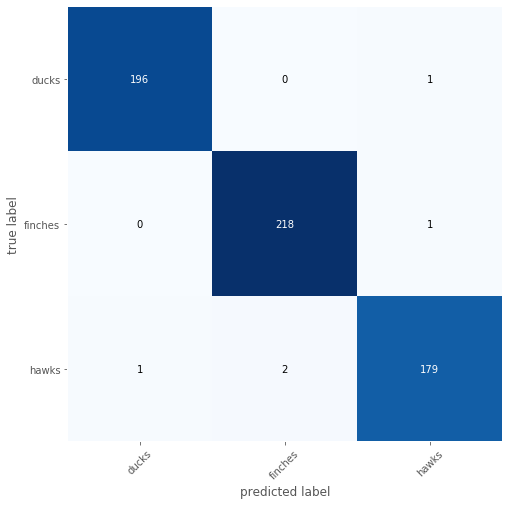

In [74]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

pred1 = transfer_model.predict(X_test)

y_true = y_test.copy()

y_true = np.array([i.argmax() for i in y_true]).reshape(-1,1)

y_predicted = (pred1 > 0.5).astype(float)

y_predicted = np.array([i.argmax() for i in y_predicted]).reshape(-1,1)

mat = confusion_matrix(y_true, y_predicted)

plot_confusion_matrix(conf_mat=mat, figsize=(8,8), class_names=folders);

# plt.savefig('graphs/modelx_7_conf_mat.png')

In [ ]:
print('Transfer Model1: Loss and Accuracy')
evaluate = transfer_model.evaluate(X_test, y_test)

In [75]:
xception_final = transfer_model.fit(X, y, batch_size = 32, epochs=6, validation_split=0.1)

Epoch 1/6
84/84 [==============================] - 493s 6s/step - loss: 0.0203 - accuracy: 0.9937 - val_loss: 0.0365 - val_accuracy: 0.9900
Epoch 2/6
84/84 [==============================] - 493s 6s/step - loss: 0.0168 - accuracy: 0.9948 - val_loss: 0.0370 - val_accuracy: 0.9900
Epoch 3/6
84/84 [==============================] - 493s 6s/step - loss: 0.0150 - accuracy: 0.9955 - val_loss: 0.0560 - val_accuracy: 0.9799
Epoch 4/6
84/84 [==============================] - 494s 6s/step - loss: 0.0132 - accuracy: 0.9963 - val_loss: 0.0462 - val_accuracy: 0.9866
Epoch 5/6
84/84 [==============================] - 493s 6s/step - loss: 0.0108 - accuracy: 0.9970 - val_loss: 0.0998 - val_accuracy: 0.9532
Epoch 6/6
84/84 [==============================] - 494s 6s/step - loss: 0.0097 - accuracy: 0.9963 - val_loss: 0.1000 - val_accuracy: 0.9565


In [78]:
# transfer_model.save('saved_models/xception_final.h5')
load_xception = tf.keras.models.load_model('saved_models/xception_final.h5')

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import tensorflow.keras.backend as K
import shap

In [ ]:
# load pre-trained model and choose two images to explain
vgg_model = VGG16(weights='imagenet', include_top=True)
to_explain = X[[39,41]]

# load the ImageNet class names
# url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
# fname = shap.datasets.cache(url)
# with open(fname) as f:
#     class_names = json.load(f)

# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([vgg_model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)
e = shap.GradientExplainer(
    (model.layers[7].input, model.layers[-1].output),
    map2layer(X, 7),
    local_smoothing=0 # std dev of smoothing noise
)
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

# get the names for the classes
# index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap.image_plot(shap_values, to_explain, label)